IMPORTOWANIE BIBLIOTEK

In [16]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch
import copy
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
import numpy as np
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.model_selection import train_test_split
from src.lung_seg import segment_lungs
from torchvision import models

1. Wyznaczenie jednostki obliczeniowej (CUDA/MPS)

In [17]:
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")

Using device: cuda


2. Wyznaczenie zbioru danych oraz segmentacja

In [18]:
datasets = {
    "mendeley": {
        "dataset_n": '.\\datasets\\mendeley\\N',
        "save_path_n": '.\\segmented_imgs\\mendeley\\N',
        "dataset_p": '.\\datasets\\mendeley\\P',
        "save_path_p": '.\\segmented_imgs\\mendeley\\P',
        "dataset": '.\\segmented_imgs\\mendeley',
    } ,
    "covidgr": {
        "dataset_n": '.\\datasets\\covidgr\\N',
        "save_path_n": '.\\segmented_imgs\\covidgr\\N',
        "dataset_p": '.\\covidgr\\P',
        "save_path_p": '.\\segmented_imgs\\covidgr\\P',
        "dataset": '.\\segmented_imgs\\covidgr',
    },
        "custom": {
        "dataset_n": '.\\datasets\\custom\\N',
        "save_path_n": '.\\segmented_imgs\\custom\\N',
        "dataset_p": '.\\datasets\\custom\\P',
        "save_path_p": '.\\segmented_imgs\\custom\\P',
        "dataset": '.\\segmented_imgs\\custom',
    },
}

# mendeley: 1626 COVID / 1802 NORMAL / 1800 PNEUMONIA
# covidgr: 426 N / 426 P
# custom: covidgr + 426 pneumonia z mendeley

run = False
path = 'custom'

if run:
    if path == 'covidgr':
        dataset_n, save_path_n, dataset_p, save_path_p, dataset = datasets['covidgr'].values()
    if path == 'mendeley':
        dataset_n, save_path_n, dataset_p, save_path_p, dataset = datasets['mendeley'].values()
    segment_lungs(dataset_n, save_path_n, run)
    segment_lungs(dataset_p, save_path_p, run)
else: 
    if path == 'covidgr':
        dataset = '.\\datasets\\covidgr'
    if path == 'mendeley':
        dataset = '.\\datasets\\mendeley'
    if path == 'custom':
        dataset = '.\\datasets\\custom'

dataset = ImageFolder(dataset)

3. Wyznaczenie hiperparametrów

In [19]:
# Hiperparametry
hparam = {
    "learning_rate": 0.005,
    "batch_size": 32,
    "num_epochs": 500,
    "es_patience": 15,
    "sch_patience": 4,
}

4. Preprocessing danych

In [20]:
class TransformSubset(Subset):
    def __init__(self, dataset, indices, transform=None):
        super(TransformSubset, self).__init__(dataset, indices)
        self.transform = transform

    def __getitem__(self, idx):
        x, y = self.dataset[self.indices[idx]]
        if self.transform:
            x = self.transform(x)
        return x, y

In [21]:
class ContrastBrightness(transforms.RandomApply):
    def __init__(self, brightness_factor):
        super().__init__([transforms.ColorJitter(brightness=brightness_factor)])

class HistEqualization(transforms.RandomApply):
    def __init__(self):
        super().__init__([transforms.RandomEqualize()])

class SmoothImage(transforms.RandomApply):
    def __init__(self, sigma):
        super().__init__([transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, sigma))])


In [22]:
def show_transformed_image(train_subset, index, transform):
    original_image, _ = train_subset.dataset[train_subset.indices[index]]
    
    transformed_image = transform(original_image)

    transformed_image_pil = transforms.ToPILImage()(transformed_image)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(original_image)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(transformed_image_pil, cmap='gray')
    ax[1].set_title('Transformed Image')
    ax[1].axis('off')

    plt.show()



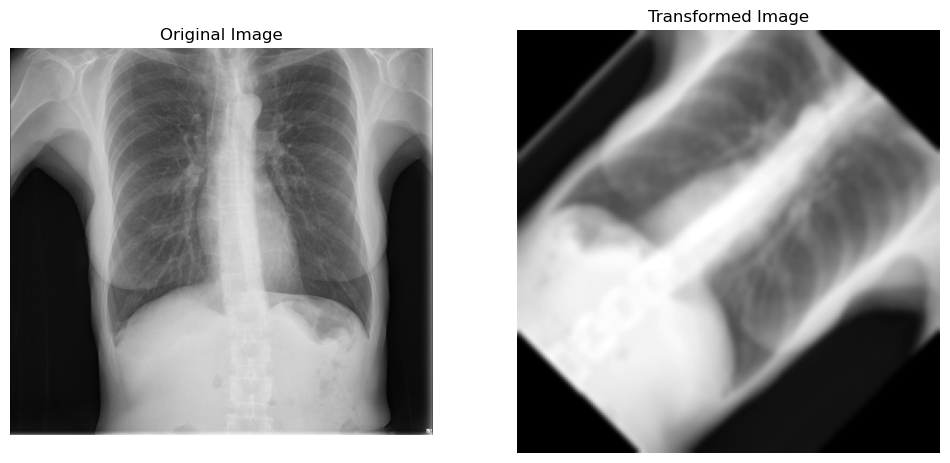

In [23]:
# Etykiety dla każdej próbki
labels = [sample[1] for sample in dataset.samples]

# Dzielenie indeksów na treningowe i testowe
train_idx, test_idx, _, _ = train_test_split(
    np.arange(len(labels)),
    labels,
    test_size=0.2, 
    random_state=42,
    stratify=labels  
)

train_transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((256, 256)),
    transforms.RandomRotation(degrees=(-10, 45)),
    transforms.RandomHorizontalFlip(),
    SmoothImage(sigma=2),
    ContrastBrightness(brightness_factor=0.2),
    HistEqualization(),
    transforms.ToTensor()
])

# Transformacje dla zbioru testowego (bez augmentacji)
test_transform = transforms.Compose([
    transforms.Grayscale(1), 
    transforms.Resize((256, 256)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

# Tworzenie podzbiorów dla danych treningowych i testowych
train_subset = Subset(dataset, train_idx)
train_labels = [labels[i] for i in train_idx]

test_subset = TransformSubset(dataset, test_idx, transform=test_transform)
test_labels = [labels[i] for i in test_idx]
test_loader = DataLoader(test_subset, batch_size=hparam["batch_size"], shuffle=True) 

# Kryterium strat
criterion = nn.BCEWithLogitsLoss()

show_transformed_image(train_subset, 0, train_transform)


5. Stworzenie CNN

In [24]:
class CovidNet(nn.Module):
    def __init__(self):
        super(CovidNet, self).__init__()
        # Pierwsza warstwa konwolucyjna
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Druga warstwa konwolucyjna
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Trzecia warstwa konwolucyjna
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.LeakyReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Warstwy w pełni połączone (Dense)
        self.fc1 = nn.Linear(128 * 32 * 32, 512)  
        self.relu4 = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 128)
        self.relu5 = nn.LeakyReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 1)  

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))

        x = x.view(x.size(0), -1)  #
        x = self.dropout1(self.relu4(self.fc1(x)))
        x = self.dropout2(self.relu5(self.fc2(x)))
        x = self.fc3(x)

        return x 


In [25]:
class CustomResNet18(nn.Module):
    def __init__(self, num_classes=1, dropout_rate=0.3):
        super(CustomResNet18, self).__init__()

        self.resnet18 = models.resnet18(pretrained=True)
        num_ftrs = self.resnet18.fc.in_features

        self.resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.resnet18.fc = nn.Sequential(
            nn.Dropout(dropout_rate), 
            nn.Linear(num_ftrs, 512),  
            nn.BatchNorm1d(512),  
            nn.ReLU(),  
            nn.Linear(512, num_classes)  
        )
        
    def forward(self, x):
        return self.resnet18(x)



6. Trenowanie i testowanie sieci 

In [26]:
class EarlyStopping:
    def __init__(self, patience=hparam['es_patience'], min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False

In [27]:
def validate(model, loader):
    loss_num = loss_denom = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            labels = labels.float()
            outputs = model(inputs.to(device))
            outputs = outputs.squeeze(1)
            loss_num += criterion(outputs, labels.to(device))
            loss_denom += 1

    return loss_num / loss_denom

In [28]:
def plot_roc_curve(fper, tper, title='ROC Curve'):
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend()
    plt.show()

In [29]:
def plot_confusion_matrix(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

Fold #1


c:\Users\Jakub\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Jakub\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch: 1, epoch_loss: 17.064441, vloss: 28.816889, : 100%|██████████| 26/26 [00:15<00:00,  1.73it/s]
Epoch: 2, epoch_loss: 12.634743, vloss: 0.532239, Improvement found, counter reset to 0: 100%|██████████| 26/26 [00:14<00:00,  1.78it/s]
Epoch: 3, epoch_loss: 11.678213, vloss: 0.497756, Improvement found, counter reset to 0: 100%|██████████| 26/26 [00:15<00:00,  1.73it

_____________________________________________________________________________
Fold #1 Sensitivity: 0.6941176470588235
Fold #1 Specificity: 0.8070175438596491
Fold #1 Precision:   0.6413043478260869
Fold #1 F1 Score:    0.6666666666666666
Fold #1 Accuracy:    0.76953125
Fold #1 ROC AUC:     0.8579979360165119


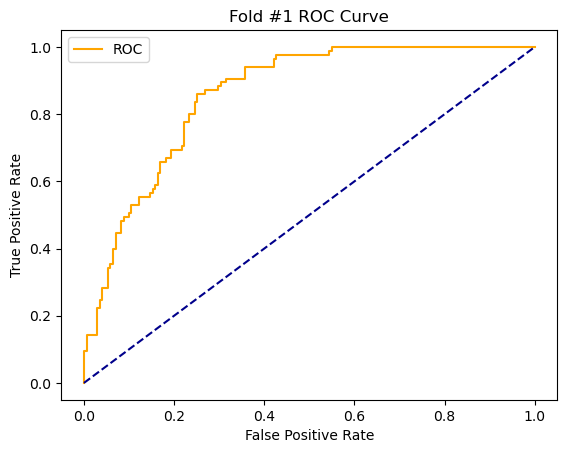

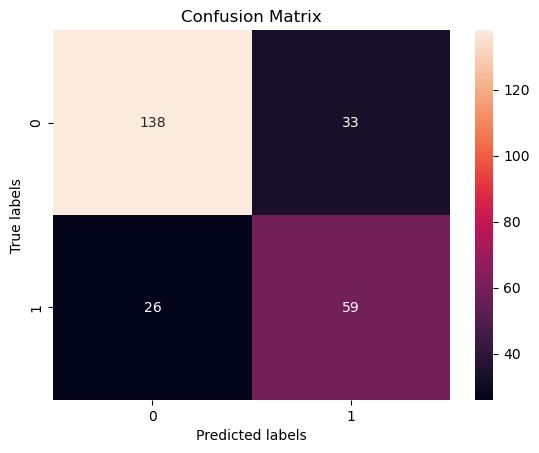

Fold #2


c:\Users\Jakub\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Jakub\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch: 1, epoch_loss: 16.411539, vloss: 14.884672, : 100%|██████████| 26/26 [00:15<00:00,  1.71it/s]
Epoch: 2, epoch_loss: 12.394712, vloss: 0.722845, Improvement found, counter reset to 0: 100%|██████████| 26/26 [00:14<00:00,  1.74it/s]
Epoch: 3, epoch_loss: 11.921379, vloss: 0.631486, Improvement found, counter reset to 0: 100%|██████████| 26/26 [00:14<00:00,  1.75it

Epoch 00049: reducing learning rate of group 0 to 2.5000e-04.


_____________________________________________________________________________
Fold #2 Sensitivity: 0.7764705882352941
Fold #2 Specificity: 0.8830409356725146
Fold #2 Precision:   0.7674418604651163
Fold #2 F1 Score:    0.7719298245614037
Fold #2 Accuracy:    0.84765625
Fold #2 ROC AUC:     0.9234262125902993


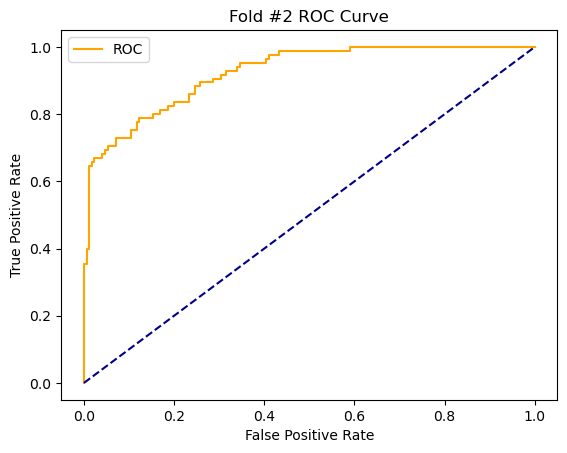

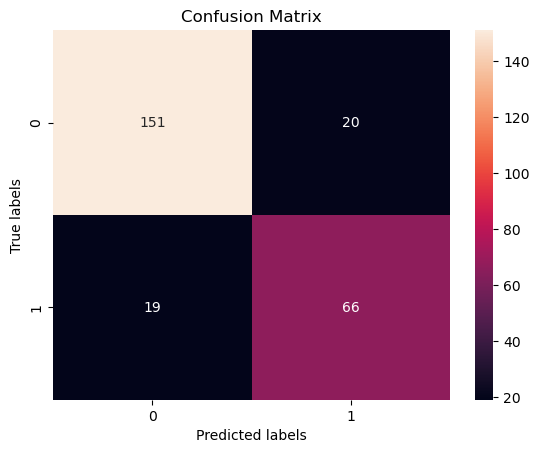

Fold #3


c:\Users\Jakub\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Jakub\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch: 1, epoch_loss: 15.953150, vloss: 0.685131, : 100%|██████████| 26/26 [00:15<00:00,  1.64it/s]
Epoch: 2, epoch_loss: 12.784840, vloss: 0.574015, Improvement found, counter reset to 0: 100%|██████████| 26/26 [00:15<00:00,  1.66it/s]
Epoch: 3, epoch_loss: 12.359663, vloss: 0.579672, No improvement in the last 1 epochs: 100%|██████████| 26/26 [00:15<00:00,  1.66it/s]

Epoch 00035: reducing learning rate of group 0 to 2.5000e-04.



Epoch: 36, epoch_loss: 1.647667, vloss: 0.634132, No improvement in the last 13 epochs: 100%|██████████| 26/26 [00:14<00:00,  1.80it/s]
Epoch: 37, epoch_loss: 1.399587, vloss: 0.661944, No improvement in the last 14 epochs: 100%|██████████| 26/26 [00:14<00:00,  1.79it/s]
Epoch: 38, epoch_loss: 1.636136, vloss: 0.664640, Early stopping triggered after 15 epochs.: 100%|██████████| 26/26 [00:14<00:00,  1.79it/s]


_____________________________________________________________________________
Fold #3 Sensitivity: 0.6823529411764706
Fold #3 Specificity: 0.9064327485380117
Fold #3 Precision:   0.7837837837837838
Fold #3 F1 Score:    0.7295597484276729
Fold #3 Accuracy:    0.83203125
Fold #3 ROC AUC:     0.9079463364293086


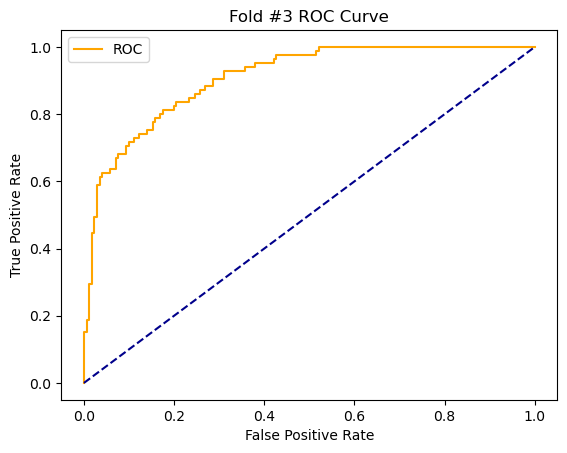

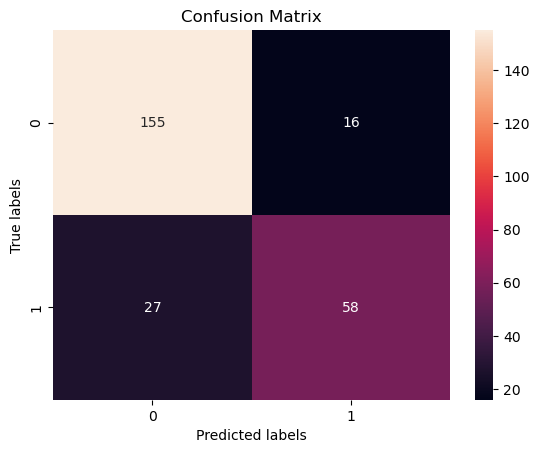

Fold #4


c:\Users\Jakub\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Jakub\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch: 1, epoch_loss: 16.357691, vloss: 26.233580, : 100%|██████████| 26/26 [00:14<00:00,  1.77it/s]
Epoch: 2, epoch_loss: 12.333352, vloss: 0.746495, Improvement found, counter reset to 0: 100%|██████████| 26/26 [00:14<00:00,  1.76it/s]
Epoch: 3, epoch_loss: 11.882732, vloss: 0.665812, Improvement found, counter reset to 0: 100%|██████████| 26/26 [00:14<00:00,  1.77it

_____________________________________________________________________________
Fold #4 Sensitivity: 0.7411764705882353
Fold #4 Specificity: 0.8421052631578947
Fold #4 Precision:   0.7
Fold #4 F1 Score:    0.72
Fold #4 Accuracy:    0.80859375
Fold #4 ROC AUC:     0.8637082903336772


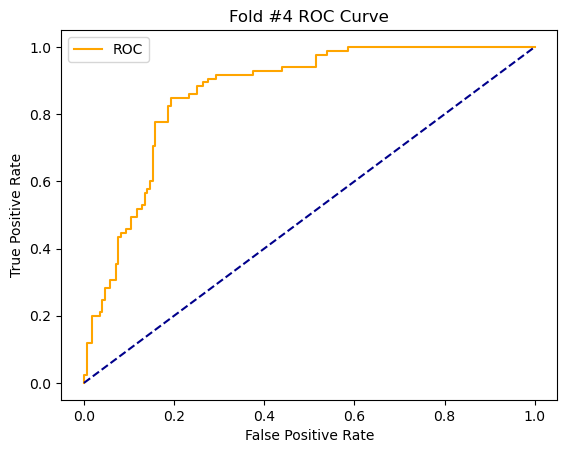

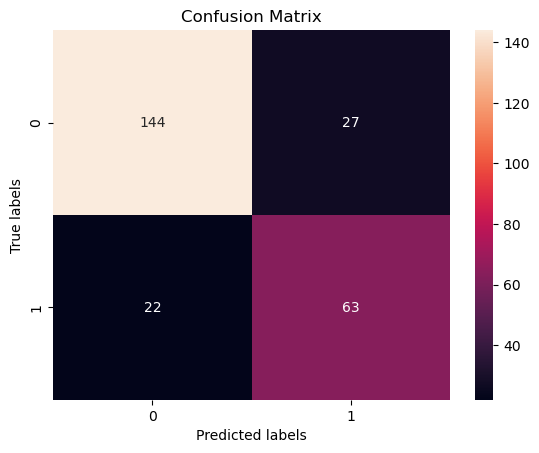

Fold #5


c:\Users\Jakub\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Jakub\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch: 1, epoch_loss: 17.836716, vloss: 290.220795, : 100%|██████████| 26/26 [00:14<00:00,  1.80it/s]
Epoch: 2, epoch_loss: 12.695728, vloss: 0.819898, Improvement found, counter reset to 0: 100%|██████████| 26/26 [00:14<00:00,  1.81it/s]
Epoch: 3, epoch_loss: 12.457344, vloss: 1.886619, No improvement in the last 1 epochs: 100%|██████████| 26/26 [00:14<00:00,  1.80it/

_____________________________________________________________________________
Fold #5 Sensitivity: 0.6588235294117647
Fold #5 Specificity: 0.9064327485380117
Fold #5 Precision:   0.7777777777777778
Fold #5 F1 Score:    0.7133757961783439
Fold #5 Accuracy:    0.82421875
Fold #5 ROC AUC:     0.8864809081527348


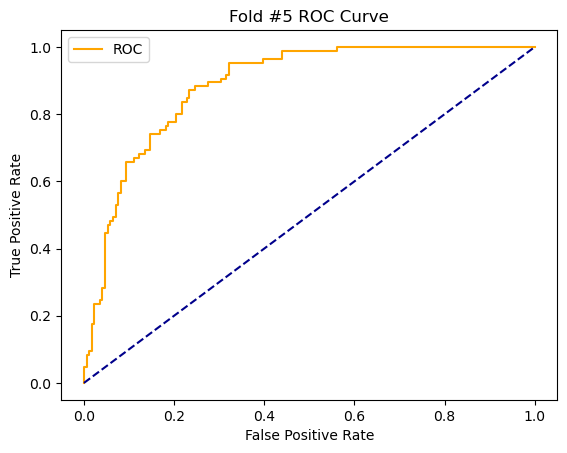

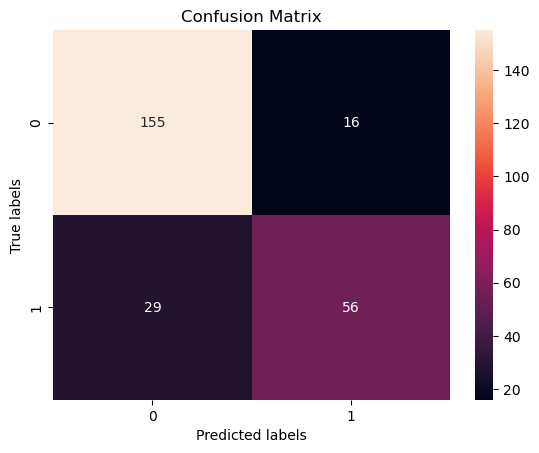

In [30]:
# Inicjalizacja StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Inicjalizacja tablic do późniejszego obliczenia finalnych metryk
oos_y = []
oos_pred = []   
oos_prob = []

# Pętla cross-validacyjna
for fold, (train_idx, val_idx) in enumerate(skf.split(np.arange(len(train_subset)), train_labels)):  
    
    print(f"Fold #{fold + 1}")

    # Dzielenie zbioru danych według indeksów z stratifiedfold
    train_subset = TransformSubset(dataset, train_idx, transform=test_transform)
    val_subset = Subset(dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=hparam["batch_size"], shuffle=True)
    val_loader = DataLoader(test_subset, batch_size=hparam["batch_size"], shuffle=True) 

    # Resetowanie modelu i optymalizatora
    model = CustomResNet18().to(device) #CovidNetTransfer()

    optimizer = optim.Adam(model.parameters(), lr=hparam["learning_rate"])
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=hparam['sch_patience'], verbose=True)

    # Opcjonalnie
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=hparam["sch_patience"], threshold=0.0001, threshold_mode='rel', cooldown=0, eps=1e-08, verbose=True)

    # Inicjalizacja early-stop
    es = EarlyStopping(restore_best_weights=True)  
    done = False

    # Główna pętla ucząca
    epoch = 0
    while not done and epoch < hparam["num_epochs"]:
        epoch += 1
        epoch_loss = 0
        vloss = 0
        steps = list(enumerate(train_loader))
        pbar = tqdm(steps)

        model.train()
        for i, (images, labels) in pbar:
            
            batch_loss = 0
            
            labels = labels.float()
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            outputs = outputs.squeeze(1)

            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss = loss.item() 
            epoch_loss += batch_loss * hparam['batch_size']
            
            # Walidacja i sprawdzanie warunku early-stop
            if i == len(steps) - 1:
                model.eval()
                vloss = validate(model, val_loader)
                epoch_loss /= len(steps) 
                scheduler.step(epoch_loss)
                if es(model, vloss):
                    done = True
                pbar.set_description(
                    f"Epoch: {epoch}, epoch_loss: {epoch_loss:>7f}, vloss: {vloss:>7f}, {es.status}"
                )

            else:
                pbar.set_description(f"Epoch: {epoch}, batch_loss {batch_loss:>7f}")

    # Sprawdzanie z podzbiorem testowym
    fold_y = []
    fold_pred = []
    fold_prob = []

    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            
            images = images.to(device)
            y_val = model(images)
            probabilities = torch.sigmoid(y_val)
            predicted_classes = (probabilities > 0.5).int()
            
            fold_y.extend(labels.cpu().numpy())
            fold_pred.extend(predicted_classes.cpu().numpy())
            fold_prob.extend(probabilities.cpu().numpy())
            
            oos_y.append(labels.cpu().numpy())
            oos_pred.append(predicted_classes.cpu().numpy())
            oos_prob.append(probabilities.cpu().numpy())
    
    # Obliczanie metryk dla k-tego foldu foldu
    sensitivity = recall_score(fold_y, fold_pred)
    specificity = recall_score(fold_y, fold_pred, pos_label=0)
    precision = precision_score(fold_y, fold_pred)
    f1 = f1_score(fold_y, fold_pred)
    score = accuracy_score(fold_y, fold_pred)
    fold_fper, fold_tper, thresholds = roc_curve(fold_y, fold_prob)
    roc_auc = auc(fold_fper, fold_tper)

    # Wypisanie metryk dla k-tego foldu
    print('_____________________________________________________________________________')
    print(f"Fold #{fold+1} Sensitivity: {sensitivity}")
    print(f"Fold #{fold+1} Specificity: {specificity}")
    print(f"Fold #{fold+1} Precision:   {precision}")
    print(f"Fold #{fold+1} F1 Score:    {f1}")        
    print(f"Fold #{fold+1} Accuracy:    {score}")
    print(f"Fold #{fold+1} ROC AUC:     {roc_auc}")
    
    # Tworzenie wykresów dla k-tego foldu
    plot_roc_curve(fold_fper, fold_tper, f'Fold #{fold+1} ROC Curve')
    plot_confusion_matrix(fold_y, fold_pred)


7. Końcowa walidacja 

_____________________________________________________________________________
Final Sensitivity:  0.7105882352941176
Final Specificity:  0.8690058479532163
Final Precision:    0.7294685990338164
Final F1 Score:     0.7199046483909416
Final Accuracy:     0.81640625
Final ROC AUC:      0.8881486068111456


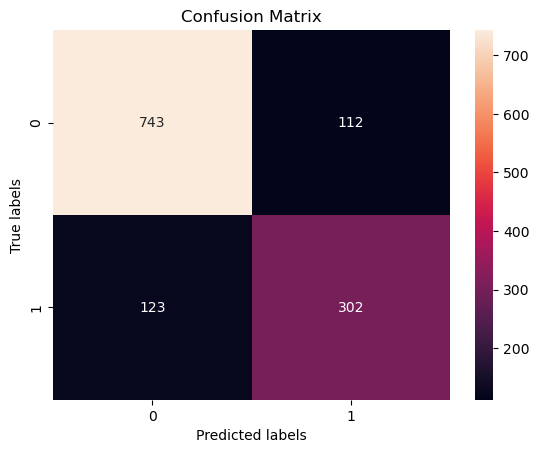

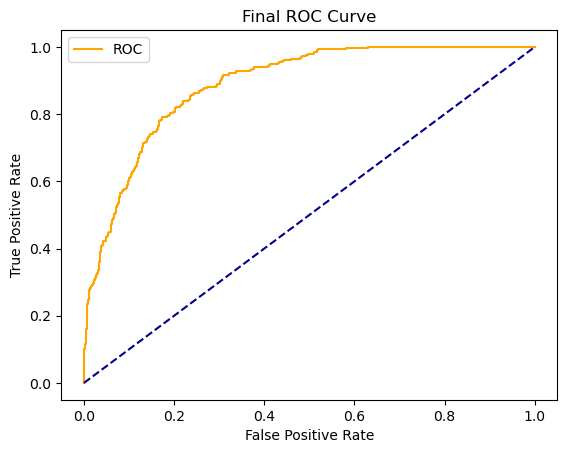

In [31]:
# Konkatynacja list
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
oos_prob = np.concatenate(oos_prob)

# Obliczanie końcowych metryk
sensitivity = recall_score(oos_y, oos_pred)
specificity = recall_score(oos_y, oos_pred, pos_label=0)
precision = precision_score(oos_y, oos_pred)
f1 = f1_score(oos_y, oos_pred)
score = accuracy_score(oos_y, oos_pred)
fper, tper, thresholds = roc_curve(oos_y, oos_prob)
roc_auc = auc(fper, tper)

# Wypisanie końcowych metryk
print('_____________________________________________________________________________')
print(f"Final Sensitivity:  {sensitivity}")
print(f"Final Specificity:  {specificity}")
print(f"Final Precision:    {precision}")
print(f"Final F1 Score:     {f1}")        
print(f"Final Accuracy:     {score}")
print(f"Final ROC AUC:      {roc_auc}")

#Tworzenie wykresów
plot_confusion_matrix(oos_y, oos_pred)
plot_roc_curve(fper, tper, 'Final ROC Curve')

# Zapisanie modelu
torch.save(model.state_dict(), 'models/covid_net.pth')